In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import numpy as np
import random
import torch

def enforce_reproducibility(seed=42):
  # Sets seed manually for both CPU and CUDA
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  # For atomic operations there is currently no simple way to enforce 
  # determinism, as the order of parallel operations is not known.
  # CUDNN
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  
  # System based
  random.seed(seed)
  np.random.seed(seed)

enforce_reproducibility()

In [4]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2020-10-26 15:43:41--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  81.3MB/s    in 7.3s    

2020-10-26 15:43:48 (89.4 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [5]:
pip install pytorch-crf

In [6]:
!pip install langdetect

     |████████████████████████████████| 983kB 4.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=b47f4b750ce2a24bdb8fbecfb263f205b72ae15abdd31e1233ca87a9f68c4ca6
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [9]:
#a4_data2label

import json
from langdetect import detect
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer as twt

# Task 4.1

# We want to convert the JSON-files to a format of tokens (words) along an IOB tag
# This tag corresponds to whether the given token is
#  - the beginning (B) of the answer
#  - inside (I) the answer
#  - outise (O) the answer
#
#
# We store the resulting tagged words in a file.
# We separate each context in this file with a blank line
# This blank line is used for the implementation of the models

# The method used is quite simple:
# ctx[answ_start] = B
# ctx[answ_start + 1:len(answ)] = I
# ctx[else] = O

i_twt = twt()

def get_data_lines(s):
    retval = []
    with open("/content/drive/My Drive/NLP 2020W/tydiqa-goldp-v1.1-"+s+".json","r") as f:
        retval = f.readlines()
    return retval

def store_result(fname,txt):
    with open("/content/drive/My Drive/NLP 2020W/data/"+fname+".txt","w") as f:
        f.write(txt)

def create_tokens(txt):
    # create tokens along their position
    # output : [(token,pos)]
    res = []
    tks = list(i_twt.tokenize(txt))
    tks_pos = list(i_twt.span_tokenize(txt))
    return [(tks[i],tks_pos[i]) for i in range(0,len(tks))]

def data2iob(lines,pred):
    # create a string of tokens and IOB-tags.
    # the token and the tag is separated by a space
    # each entry is separated by a new line
    #### args
    # pred = predicate for filtering result

    #so use dumps to parse all lines of input
    jdumps = json.dumps(lines)

    #and then load the dumps
    jdata = json.loads(jdumps)

    res = ""
    ctxs = ""
    lang = ""

    # get data
    jd = jdata[0]
    jd_obj = json.loads(jd)
    k_data = jd_obj["data"]
    k_version = jd_obj["version"]

    # loop over paragraphs that is nested inside k_data
    for kd in k_data:
        title = kd["title"]
        parg = kd["paragraphs"][0]
        ctx = parg["context"]
        qas = parg["qas"][0]
        qas_question = qas["question"]
        qas_answers = qas["answers"]
        qas_id = qas["id"]
        lang = qas_id.split("-")[0]
        
        # predicate to use for filtering the result
        pred_data = {
                "lang":lang,
                "title":title,
                "ctx":ctx
                }

        answ_start = qas_answers[0]["answer_start"]
        answ_txt = qas_answers[0]["text"]
        
        tks = None
        try:
            # we need to try since at least one context is malformed
            # which will make span_tokenizer fail
            tks = create_tokens(ctx)
        except:
            print("malformed ctx!")
            #print("****title=" + title)
            #print("****lang=" + lang)
            #print("****ctx=" + ctx)

        # loop over tokens
        # store each along the IOB tag as a string
        # tag and token are seperated by a single space
        tag_res = ""
        if tks != None and pred(pred_data):
            ctxs += ctx + "\n"
            for (w,pos) in tks:
                #tag_res += w + str(pos) + " "
                tag_res += w + " "
                if pos[0] == answ_start:
                    tag_res += "B"
                elif pos[0] < answ_start + len(answ_txt) and pos[0] > answ_start:
                    tag_res += "I"
                else:
                    tag_res += "O"
                tag_res += "\n"
        
            res += tag_res
            res += "\n"

    return (res,ctxs)



#get file

exe_set = "train"

f_lines = get_data_lines(exe_set)

# filter predicates
def pred_all(pred_data):
    return True

def pred_en(pred_data):
    if pred_data["lang"] == "english":
        return True
    else:
        return False

def pred_fi(pred_data):
    if pred_data["lang"] == "finnish":
        return True
    else:
        return False

def pred_ar(pred_data):
    if pred_data["lang"] == "arabic":
        return True
    else:
        return False

def pred_ko(pred_data):
    if pred_data["lang"] == "korean":
        return True
    else:
        return False

#execute
(res,ctxs) = data2iob(f_lines,pred_en)
store_result(exe_set + "-eng-iobtagged",res)

(res,ctxs) = data2iob(f_lines,pred_fi)
store_result(exe_set + "-fin-iobtagged",res)

(res,ctxs) = data2iob(f_lines,pred_ar)
store_result(exe_set + "-ara-iobtagged",res)

(res,ctxs) = data2iob(f_lines,pred_ko)
store_result(exe_set + "-kor-iobtagged",res)

print("done")


Streaming output truncated to the last 5000 lines.
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malformed ctx!
malf

In [12]:
#data_reader

import sys
import io
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from torchcrf import CRF
from torch.optim.lr_scheduler import ExponentialLR, CyclicLR
from typing import List, Tuple, AnyStr
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from copy import deepcopy
#from data_reader import * 

def read_data(filename, splitchar = '\t'):
    # read in the data.
    # the data is rightly tagged

    # Tokenization is not an issue since the data is already listed in tokens (words)
    dataset = []
    with open(filename) as f:
        data = f.read()
        samples = data.split('\n\n')
        for s in samples:
            if s:
                tok_idx = [t.split(splitchar) for t in s.strip().split('\n')]
                tokens,idx = zip(*tok_idx)
                tokens = list(tokens)
                idx = list(idx)
                dataset.append([tokens,idx])
    return dataset

# set data
def setdata(language):
    data = read_data("/content/drive/My Drive/NLP 2020W/data/train-"+language+"-iobtagged.txt",splitchar = " ")

    # Divide into train,dev,test and so on.
    # The dev-set has been handed out. So data is divided into test and trian
    random.shuffle(data)
    test_idx = int(len(data) * 0.9)
    test_data = data[test_idx:]
    train_data = data[:test_idx]
    dev_idx = int(len(train_data) * 0.9)
    dev_data = train_data[dev_idx:]
    train_data = train_data[0:dev_idx]
    #dev_data = read_data("data/dev-eng-iobtagged.txt",splitchar = " ")
    #random.shuffle(dev_data)

    #print1 = [(t, l) for t,l in zip(train_data[5][0], train_data[5][1])]

    # A map of labels, eg. label-vocab.
    # label_map = {'B': 0, 'O': 1, 'I': 2}
    # where the numbers each field points to, is an index
    label_map = {l:i for i,l in enumerate((set([l for s in train_data for l in s[1]]) | set([l for s in dev_data for l in s[1]]) | set([l for s in test_data for l in s[1]])))}
    num_labels = len(label_map)
    return dev_data, train_data, data, test_data, label_map, num_labels

dev_data, train_data, data, test_data, label_map, num_labels = setdata("eng")

def load_vectors(fname, vocabulary):
    # create vectors for word embeddings. As in the lab we use all of train and dev
    # plus most common words word embeddings

    # load vectors from pretrained embeddings
    # each vector consists of the given word followed by the embedding
    # for the pretrained model we use, we have vec length of 1 + 300
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')

    n, d = map(int, fin.readline().split())

    # define utlity tokens
    # the embeddings might clash with pretrained if we are very unlucky?
    PAD_vec,PAD_tok = np.random.normal(size=(300,)),'[PAD]'
    UNK_vec,UNK_tok = np.random.normal(size=(300,)),'[UNK]'
    BOS_vec,BOS_tok = np.random.normal(size=(300,)),'[BOS]'
    EOS_vec,EOS_tok = np.random.normal(size=(300,)),'[EOS]'

    # final vocabulary is org vocabulary + the 4 tokens below + the most common from pretrained
    final_vocab = [PAD_tok, UNK_tok , BOS_tok, EOS_tok]

    # final vectors are vectors corresponding to the final vocab
    final_vectors = [PAD_vec, UNK_vec, BOS_vec, EOS_vec]

    # iterate pretrained word embs
    for j,line in enumerate(fin):
        word_emb = line.rstrip().split(' ')
        if word_emb[0] in vocabulary or len(final_vocab) < 700000:
            # check if the current word embedding is in vocab or if the max-cap is reached

            # the second condition is the nr of extra tokens to include
            # in lab the org vocabsize is 8013, extra is 30000. Hence roughly 20000 extra
            # here we have org voc of ~46000, so plus 20000 and we are at 70000
            final_vocab.append(word_emb[0])
            final_vectors.append(np.array(list(map(float, word_emb[1:]))))
    return final_vocab, np.vstack(final_vectors)

# Load all vocabulary as words from the training set along the dev set
vocabulary = (set([t for s in train_data for t in s[0]]) | set([t for s in dev_data for t in s[0]]))
vocabulary, pretrained_embeddings = load_vectors('wiki-news-300d-1M.vec', vocabulary)

print2 = len(vocabulary)
#print(print2) # = 701152, in lab6 we have vocabsize = 31601


def collate_batch_bilstm(input_data: Tuple) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    input_ids = [i[0][0] for i in input_data]
    seq_lens = [i[1][0] for i in input_data]
    labels = [i[2] for i in input_data]

    max_length = max([len(i) for i in input_ids])

    input_ids = [(i + [0] * (max_length - len(i))) for i in input_ids]
    labels = [(i + [label_map['O']] * (max_length - len(i))) for i in labels]

    assert (all(len(i) == max_length for i in input_ids))
    assert (all(len(i) == max_length for i in labels))
    return torch.tensor(input_ids), torch.tensor(seq_lens), torch.tensor(labels)

def text_to_batch_bilstm(text: List, tokenizer) -> Tuple[List, List]:
    """
    Creates a tokenized batch for input to a bilstm model
    :param text: A list of sentences to tokenize
    :param tokenizer: A tokenization function to use (i.e. fasttext)
    :return: Tokenized text as well as the length of the input sequence
    """
    # Some light preprocessing
    input_ids = [tokenizer.encode(t) for t in text]

    return input_ids, [len(ids) for ids in input_ids]

class FasttextTokenizer:
    def __init__(self, vocabulary):
        # create own vocab as dict
        # with word as key and enum-id as val
        self.vocab = {}
        for j,l in enumerate(vocabulary):
            self.vocab[l.strip()] = j

    def encode(self, text):
        # Text is assumed to be tokenized
        # Returns enum-id of every token of text
        return [self.vocab[t] if t in self.vocab else self.vocab['[UNK]'] for t in text]

# This will load the dataset and process it lazily in the __getitem__ function
class NERDatasetReader(Dataset):
  def __init__(self, dataset, tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset[idx]
    # Calls the text_to_batch function
    input_ids,seq_lens = text_to_batch_bilstm([row[0]], self.tokenizer)
    labels = [label_map[l] for l in row[1]]
    return input_ids, seq_lens, labels

reader = NERDatasetReader(dev_data, FasttextTokenizer(vocabulary))
dev_dl = DataLoader(reader, batch_size=1, shuffle=False, collate_fn=collate_batch_bilstm)
print3 = next(iter(dev_dl))
# print(print3) = print of tensors

def do_print4():
    # res is a print of words, tags and so on
    print(dev_data[0])
    print(vocabulary[3285],vocabulary[60],vocabulary[2162],vocabulary[4],vocabulary[4484],
          vocabulary[524],vocabulary[52],vocabulary[1111],vocabulary[1192],vocabulary[8],
          vocabulary[5],vocabulary[683],vocabulary[5204],vocabulary[8],vocabulary[5],
          vocabulary[14131],vocabulary[6158],vocabulary[10],vocabulary[3151],vocabulary[6])


has cuda


Evaluation: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


Validation F1: 0.344691603508762, train loss: 0.1414505665660671


  0%|          | 0/311 [00:00<?, ?it/s]

Validation F1: 0.33597490825993587, train loss: 0.06584890068799161


  0%|          | 0/311 [00:00<?, ?it/s]

Validation F1: 0.33278638495738605, train loss: 0.0540614557778912


Evaluation: 100%|██████████| 1/1 [00:05<00:00,  5.70s/it]


Validation F1: 0.36283635351733023, train loss: 0.046741498424596725


Evaluation: 100%|██████████| 1/1 [00:05<00:00,  5.67s/it]


Validation F1: 0.41675206907498147, train loss: 0.039227641585890885


Evaluation: 100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


Validation F1: 0.46448349756203156, train loss: 0.031910307420914774


Evaluation: 100%|██████████| 1/1 [00:05<00:00,  5.66s/it]


Validation F1: 0.470801916155698, train loss: 0.02545211113049047


Evaluation: 100%|██████████| 1/1 [00:05<00:00,  5.62s/it]


Validation F1: 0.47117510087880526, train loss: 0.019529394520943762


  0%|          | 0/311 [00:00<?, ?it/s]

Validation F1: 0.44921889558079325, train loss: 0.014156666066994669


Evaluation: 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]

Validation F1: 0.4404235394666218, train loss: 0.010657365687290308


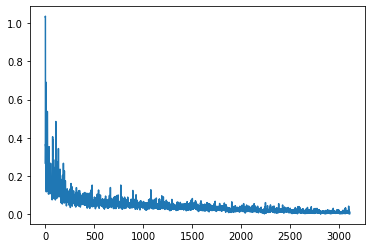

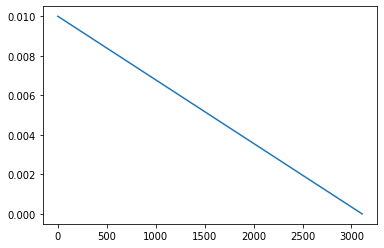

Evaluation: 100%|██████████| 307/307 [00:17<00:00, 17.95it/s]


0.8281920601251113
has cuda


Evaluation: 100%|██████████| 1/1 [00:09<00:00,  9.45s/it]


Validation F1: 0.9635572926701715, train loss: 0.15301721168891388


  0%|          | 0/676 [00:00<?, ?it/s]

Validation F1: 0.321171499745386, train loss: 0.0997555452239143


  0%|          | 0/676 [00:00<?, ?it/s]

Validation F1: 0.32913965977262405, train loss: 0.09356500645383047


  0%|          | 0/676 [00:00<?, ?it/s]

Validation F1: 0.3638697476664585, train loss: 0.0900044423313095


  0%|          | 0/676 [00:00<?, ?it/s]

Validation F1: 0.3716840274886955, train loss: 0.08646061398728183


  0%|          | 0/676 [00:00<?, ?it/s]

Validation F1: 0.3929277913727421, train loss: 0.08337850792928649


  0%|          | 0/676 [00:00<?, ?it/s]

Validation F1: 0.3430755776101184, train loss: 0.07935553060888627


  0%|          | 0/676 [00:00<?, ?it/s]

Validation F1: 0.35673886657286863, train loss: 0.07624901977736921


  0%|          | 0/676 [00:00<?, ?it/s]

Validation F1: 0.39119455790534036, train loss: 0.0727464854937686


Evaluation: 100%|██████████| 1/1 [00:09<00:00,  9.46s/it]

Validation F1: 0.3968974564460746, train loss: 0.0703745720874981


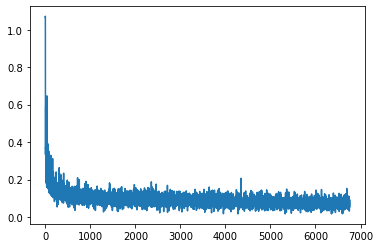

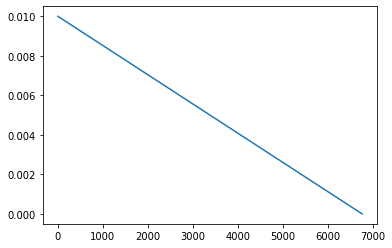

Evaluation: 100%|██████████| 307/307 [00:17<00:00, 17.63it/s]


0.9701865873445106
has cuda


Evaluation: 100%|██████████| 1/1 [00:30<00:00, 30.58s/it]


Validation F1: 0.42367942423160715, train loss: 0.09952641081831094


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation F1: 0.3552459904894078, train loss: 0.07027128114241513


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation F1: 0.3470136084277, train loss: 0.06722008578351597


Evaluation: 100%|██████████| 1/1 [00:30<00:00, 30.31s/it]


Validation F1: 0.4280134872377998, train loss: 0.06555498568910201


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation F1: 0.39696054174635337, train loss: 0.06371277073972849


Evaluation: 100%|██████████| 1/1 [00:30<00:00, 30.74s/it]


Validation F1: 0.4863766110645545, train loss: 0.06115010231122619


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation F1: 0.48286276491387164, train loss: 0.05971678481583002


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation F1: 0.45114478306893613, train loss: 0.05763010426400848


Evaluation: 100%|██████████| 1/1 [00:30<00:00, 30.65s/it]


Validation F1: 0.5191777506952773, train loss: 0.055776445794678484


Evaluation: 100%|██████████| 1/1 [00:30<00:00, 30.73s/it]


Validation F1: 0.4972084790569505, train loss: 0.0539427659628377


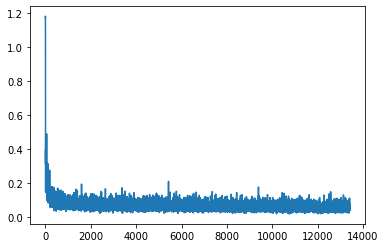

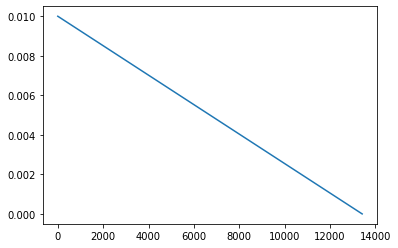

Evaluation: 100%|██████████| 307/307 [00:17<00:00, 17.36it/s]


0.3233781233274177
has cuda


Evaluation: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


Validation F1: 0.9848519518557503, train loss: 0.16483164210833093


  0%|          | 0/159 [00:00<?, ?it/s]

Validation F1: 0.9848519518557503, train loss: 0.11816334145717651


  0%|          | 0/159 [00:00<?, ?it/s]

Validation F1: 0.9848519518557503, train loss: 0.10314045045173394


  0%|          | 0/159 [00:00<?, ?it/s]

Validation F1: 0.9848519518557503, train loss: 0.10271008466165396


  0%|          | 0/159 [00:00<?, ?it/s]

Validation F1: 0.9848519518557503, train loss: 0.09915544843570616


  0%|          | 0/159 [00:00<?, ?it/s]

Validation F1: 0.9848519518557503, train loss: 0.09381367679708784


  0%|          | 0/159 [00:00<?, ?it/s]

Validation F1: 0.9848519518557503, train loss: 0.09322847921471551


  0%|          | 0/159 [00:00<?, ?it/s]

Validation F1: 0.9848519518557503, train loss: 0.09075755286235479


  0%|          | 0/159 [00:00<?, ?it/s]

Validation F1: 0.9848519518557503, train loss: 0.08912451171650076


Evaluation: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]

Validation F1: 0.9848519518557503, train loss: 0.08951483354113011


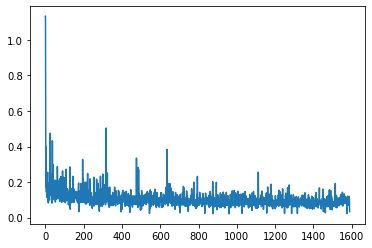

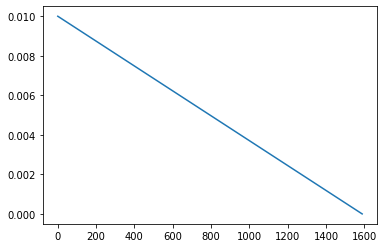

Evaluation: 100%|██████████| 307/307 [00:17<00:00, 17.28it/s]

0.9701865873445106


In [23]:
#a4_model_crf

import sys
import io
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from torchcrf import CRF
from torch.optim.lr_scheduler import ExponentialLR, CyclicLR
from typing import List, Tuple, AnyStr
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from copy import deepcopy

# link to lab6:
# https://colab.research.google.com/drive/1qy5lgp4jEu-FLDb3w_UIOxnwbk5Fykw1?usp=sharing

# we always do this 
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

enforce_reproducibility()

#from data_readers import *

"""
****Creating the model

You'll notice that the BiLSTM model is mostly the same from the text classification and language modeling labs. The differences are:

- Instead of taking a softmax/cross-entropy loss using the logits from the BiLSTM, we pass the logits to the pytorch-crf CRF module. The output of this model is the log-likelihood of the entire sequence (for each sequence in the batch). Since our objective is to minimize the loss, we take the negative of the log likelihood as our loss.
- There is now a decode function, which passes logits through the CRF to get the most likely tag sequences.
"""
# Define the model
class BiLSTM_CRF(nn.Module):
    """
    Basic BiLSTM-CRF network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(BiLSTM_CRF, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer BiLSTM, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'bilstm': nn.LSTM(
                pretrained_embeddings.shape[1],
                lstm_dim,
                2,
                batch_first=True,
                dropout=dropout_prob,
                bidirectional=True),
            'ff': nn.Linear(2*lstm_dim, n_classes),
            'CRF': CRF(n_classes, batch_first=True)
        })
        self.n_classes = n_classes

        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens, labels = None):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](inputs)

        # Pack padded: This is necessary for padded batches input to an RNN
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens,
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        lstm_out, hidden = self.model['bilstm'](lstm_in)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out,_ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Get emissions (b x seq_len x n_classes)
        emissions = self.model['ff'](lstm_out)
        outputs = (emissions,)
        if labels is not None:
            mask = (inputs != 0)
            # log-likelihood from the CRF
            log_likelihood = self.model['CRF'](emissions, labels, mask=mask, reduction='token_mean')
            outputs = (-log_likelihood,) + outputs

        return outputs

    def decode(self, emissions, mask):
      """
      Given a set of emissions and a mask, decode the sequence
      """
      return self.model['CRF'].decode(emissions, mask=mask)

def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
  # layer normalization and dropout
  model.eval()
  labels_all = []
  logits_all = []
  tags_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      _, logits = model(input_ids, seq_lens, labels=labels)
      mask = (input_ids != 0)
      labels_all.extend([l for seq,samp in zip(list(labels.detach().cpu().numpy()), input_ids) for l,i in zip(seq,samp) if i != 0])
      logits_all.extend(list(logits.detach().cpu().numpy()))
      
      tags = model.decode(logits, mask)
      tags_all.extend([t for seq in tags for t in seq])
    
    # the last param is for treating warning of none present labels/tags
    # https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi
    P, R, F1, _ = precision_recall_fscore_support(labels_all, tags_all, average='macro',labels=np.unique(tags_all))

    return F1

def train(
    model_name,
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device,
    scheduler=None
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  learning_rates = []
  best_f1 = 0.0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      # Pass the inputs through the model, get the current loss and logits
      loss, logits = model(input_ids, seq_lens, labels=labels)
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      if scheduler != None:
        scheduler.step()
        learning_rates.append(scheduler.get_last_lr()[0])
        
    #gc.collect()

    # Perform inline evaluation at the end of the epoch
    f1 = evaluate(model, valid_dl)
    print(f'Validation F1: {f1}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    if f1 > best_f1:
      torch.save(model.state_dict(), model_name)
      best_f1 = f1
        #gc.collect()

  return losses, learning_rates





def train_model():
    # Create the optimizer
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = CyclicLR(optimizer, base_lr=0., max_lr=lr, step_size_up=1, step_size_down=len(train_dl)*n_epochs, cycle_momentum=False)

    losses, learning_rates = train(model_name,model, train_dl, valid_dl, optimizer, n_epochs, device, scheduler)

    plt.plot(losses)
    plt.show()
    plt.plot(learning_rates)
    plt.show()

arr_languages = ["eng", "fin", "ara", "kor"]
for language in arr_languages: 
  dev_data, train_data, _, _, _, _ = setdata(language)
  # hyperparams
  model_name = language+"_model_crf"
  lstm_dim = 128
  dropout_prob = 0.1
  batch_size = 8
  lr = 1e-2
  n_epochs = 10

  device = torch.device("cpu")
  if torch.cuda.is_available():
      print("has cuda")
      device = torch.device("cuda")

  # Create the model
  model = BiLSTM_CRF(
      pretrained_embeddings=torch.FloatTensor(pretrained_embeddings), 
      lstm_dim=lstm_dim, 
      dropout_prob=dropout_prob, 
      n_classes=len(label_map)
    ).to(device)

  # Create the dataset readers
  train_dataset = NERDatasetReader(train_data, FasttextTokenizer(vocabulary))
  # dataset loaded lazily with N workers in parallel
  train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch_bilstm, num_workers=8)

  valid_dataset = NERDatasetReader(dev_data, FasttextTokenizer(vocabulary))
  valid_dl = DataLoader(valid_dataset, batch_size=len(dev_data), collate_fn=collate_batch_bilstm, num_workers=8)

  train_model()

  model.load_state_dict(torch.load(model_name))

  # Evaluate
  dev_dataset = NERDatasetReader(dev_data, FasttextTokenizer(vocabulary))
  dev_dl = DataLoader(dev_dataset, batch_size=len(dev_data), collate_fn=collate_batch_bilstm, num_workers=8)

  test_dataset = NERDatasetReader(test_data, FasttextTokenizer(vocabulary))
  #test_dl = DataLoader(test_dataset, batch_size=len(test_data), collate_fn=collate_batch_bilstm, num_workers=8)
  test_dl = DataLoader(test_dataset, batch_size=1, collate_fn=collate_batch_bilstm, num_workers=8)

  print5 = evaluate(model, test_dl)
  print(print5)


def last_part():
    model.eval()
    ex = 4
    samples = [b.to(device) for b in next(iter(c_dl))]

# Get the emissions. These are basically p(y|x) for each token x,
# which will be input to the CRF a decoded with the help of p(y_t|y_{t-1})
    (emissions,) = model(samples[0], samples[1])
    mask = (samples[0] != 0)

    tags = model.decode(emissions, mask)

    id_to_label = {v:k for k,v in label_map.items()}

    print10 = [(tok,id_to_label[tag]) for tok,tag in zip(test_data[ex][0], tags[ex])]
    print(print10)



has cuda


  0%|          | 0/311 [00:00<?, ?it/s]

Validation accuracy: 0.98756886689827, train loss: 0.626588881590742


  0%|          | 0/311 [00:00<?, ?it/s]

Validation accuracy: 0.98756886689827, train loss: 0.5577273213595056


  0%|          | 0/311 [00:00<?, ?it/s]

Validation accuracy: 0.98756886689827, train loss: 0.5185474873164075


  0%|          | 0/311 [00:00<?, ?it/s]

Validation accuracy: 0.9874986840720076, train loss: 0.4873921568370709


  0%|          | 0/311 [00:00<?, ?it/s]

Validation accuracy: 0.9875864126048356, train loss: 0.4564036421262183


  0%|          | 0/311 [00:00<?, ?it/s]

Validation accuracy: 0.9873232270063516, train loss: 0.42627973476023534


  0%|          | 0/311 [00:00<?, ?it/s]

Validation accuracy: 0.9877794153770573, train loss: 0.3986708075766395


  0%|          | 0/311 [00:00<?, ?it/s]

Validation accuracy: 0.9874372740990279, train loss: 0.3728299077444521


  0%|          | 0/311 [00:00<?, ?it/s]

Validation accuracy: 0.9874548198055936, train loss: 0.3540734777592386


Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Validation accuracy: 0.9877267782573604, train loss: 0.33545190397757807


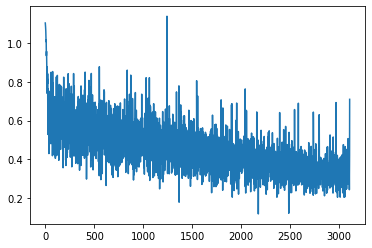

Evaluation: 100%|██████████| 307/307 [00:04<00:00, 75.75it/s] 


0.9444626797085275
has cuda


  0%|          | 0/676 [00:00<?, ?it/s]

Validation accuracy: 0.9878622864555401, train loss: 0.6345550114145646


  0%|          | 0/676 [00:00<?, ?it/s]

Validation accuracy: 0.9878622864555401, train loss: 0.554704769696357


  0%|          | 0/676 [00:00<?, ?it/s]

Validation accuracy: 0.9878622864555401, train loss: 0.48803896245342737


  0%|          | 0/676 [00:00<?, ?it/s]

Validation accuracy: 0.9879493773004588, train loss: 0.43138409884282825


  0%|          | 0/676 [00:00<?, ?it/s]

Validation accuracy: 0.9879631284864986, train loss: 0.3840100700862309


  0%|          | 0/676 [00:00<?, ?it/s]

Validation accuracy: 0.9880135495019778, train loss: 0.34244691309403386


  0%|          | 0/676 [00:00<?, ?it/s]

Validation accuracy: 0.988008965773298, train loss: 0.3089154387146411


  0%|          | 0/676 [00:00<?, ?it/s]

Validation accuracy: 0.9881739800057755, train loss: 0.2789708866170172


  0%|          | 0/676 [00:00<?, ?it/s]

Validation accuracy: 0.9879860471298982, train loss: 0.2553807646036148


Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Validation accuracy: 0.9879539610291388, train loss: 0.23491606312478788


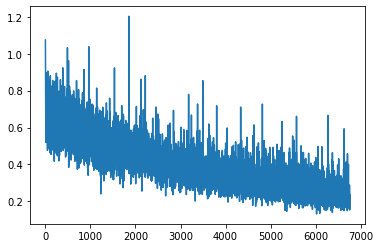

Evaluation: 100%|██████████| 307/307 [00:04<00:00, 76.33it/s] 


0.9420337425326594
has cuda


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation accuracy: 0.9918273260687342, train loss: 0.6027131612272447


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation accuracy: 0.9918260787131282, train loss: 0.4555982041732032


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation accuracy: 0.9921516385263242, train loss: 0.35024987440972677


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation accuracy: 0.9921291861254141, train loss: 0.27346290951114477


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation accuracy: 0.9923848940246677, train loss: 0.2203003971180955


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation accuracy: 0.9924559932942163, train loss: 0.18125120516527782


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation accuracy: 0.9925657605875544, train loss: 0.15439291998477522


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation accuracy: 0.9926094180337685, train loss: 0.13548466316167537


  0%|          | 0/1342 [00:00<?, ?it/s]

Validation accuracy: 0.9924996507404303, train loss: 0.1223649449130151


Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Validation accuracy: 0.9927154432602882, train loss: 0.11189869088960476


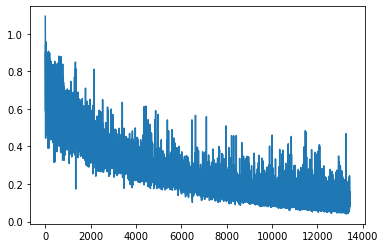

Evaluation: 100%|██████████| 307/307 [00:04<00:00, 73.95it/s] 


0.9420993894833585
has cuda


  0%|          | 0/159 [00:00<?, ?it/s]

Validation accuracy: 0.992732143249237, train loss: 0.6408568586006105


  0%|          | 0/159 [00:00<?, ?it/s]

Validation accuracy: 0.992732143249237, train loss: 0.6052573016791973


  0%|          | 0/159 [00:00<?, ?it/s]

Validation accuracy: 0.992732143249237, train loss: 0.5857867930061037


  0%|          | 0/159 [00:00<?, ?it/s]

Validation accuracy: 0.992732143249237, train loss: 0.5686889791263724


  0%|          | 0/159 [00:00<?, ?it/s]

Validation accuracy: 0.992732143249237, train loss: 0.5536263685368892


  0%|          | 0/159 [00:00<?, ?it/s]

Validation accuracy: 0.992732143249237, train loss: 0.5305867217153123


  0%|          | 0/159 [00:00<?, ?it/s]

Validation accuracy: 0.992732143249237, train loss: 0.5145016260585695


  0%|          | 0/159 [00:00<?, ?it/s]

Validation accuracy: 0.992732143249237, train loss: 0.4909840910314764


  0%|          | 0/159 [00:00<?, ?it/s]

Validation accuracy: 0.992732143249237, train loss: 0.47895513428082254


Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Validation accuracy: 0.992732143249237, train loss: 0.4625891323359507


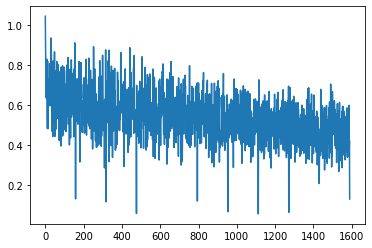

Evaluation: 100%|██████████| 307/307 [00:04<00:00, 75.73it/s] 


0.9420993894833585


In [21]:
#a4_model_noncrf

import sys
import io
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from torchcrf import CRF
from torch.optim.lr_scheduler import ExponentialLR, CyclicLR
from typing import List, Tuple, AnyStr
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from copy import deepcopy

# link to lab6:
# https://colab.research.google.com/drive/1qy5lgp4jEu-FLDb3w_UIOxnwbk5Fykw1?usp=sharing

# we always do this 
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

enforce_reproducibility()

#from data_readers import *

"""
Creating the model
This differs from 
"""
lstm_dim = 128
# Define the model
class BiLSTMNetwork(nn.Module):
    """
    Basic BiLSTM network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(BiLSTMNetwork, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer BiLSTM, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'bilstm': nn.LSTM(
                pretrained_embeddings.shape[1],
                lstm_dim,
                2,
                batch_first=True,
                dropout=dropout_prob,
                bidirectional=True),
            'ff': nn.Linear(2*lstm_dim, n_classes)
        })
        self.n_classes = n_classes

        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens, labels = None):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](inputs)

        # Pack padded: This is necessary for padded batches input to an RNN
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens,
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        lstm_out, hidden = self.model['bilstm'](lstm_in)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out,_ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Some magic to get the last output of the BiLSTM for classification (b x 2*lstm_dim)
        #ff_in = lstm_out.gather(1, input_lens.view(-1,1,1).expand(lstm_out.size(0), 1, lstm_out.size(2)) - 1).squeeze()

        # Get logits (batch_size x seq_len x n_labels)
        logits = self.model['ff'](lstm_out)
        #logits = self.model["ff"](ff_in)
        outputs = (logits,)
        if labels is not None:
            # Xentropy loss - this can only be used with a target of dim = 1
            # Hence we flatten
            loss_fn = nn.CrossEntropyLoss(reduction="mean")
            # We flatten labels to have shape (batch_size * seq_len)
            labels_flat = labels.flatten()
            # We flatten logits to have shape (batch_size * seq_len x n_labels)
            logits_flat = logits.flatten(end_dim=1)
            loss = loss_fn(logits_flat, labels_flat)
            outputs = (loss,) + outputs

        return outputs


def accuracy(logits, labels):
    logits = np.array(logits)
    labels = np.array(labels)
    return np.sum(np.argmax(logits, axis=-1) == labels).astype(np.float32) / float(labels.shape[0])

def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
  # layer normalization and dropout
  model.eval()
  labels_all = []
  logits_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      _, logits = model(input_ids, seq_lens, labels=labels)

      logits = logits.flatten(end_dim=1)
      labels = labels.flatten()

      labels_all.extend(list(labels.detach().cpu().numpy()))
      logits_all.extend(list(logits.detach().cpu().numpy()))
    acc = accuracy(logits_all, labels_all)

    return acc


def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_acc = 0.0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      # Pass the inputs through the model, get the current loss and logits
      loss, logits = model(input_ids, seq_lens, labels=labels)
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      #gc.collect()

    # Perform inline evaluation at the end of the epoch
    acc = evaluate(model, valid_dl)
    print(f'Validation accuracy: {acc}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    best_model = model.state_dict()
    if acc > best_acc:
      best_model = model.state_dict()
      best_acc = acc
        #gc.collect()

  model.load_state_dict(best_model)
  return model, losses

def train_model(model):
    # Create the optimizer
    optimizer = Adam(model.parameters(), lr=lr)

    # Train
    model, losses = train(model, train_dl, valid_dl, optimizer, n_epochs, device)

    # save best model configuration
    torch.save(model.state_dict(), model_name)
    
    plt.plot(losses)
    plt.show()


arr_languages = ["eng", "fin", "ara", "kor"]
for language in arr_languages: 
  dev_data, train_data, _, _, _, _ = setdata(language)
  # hyperparams
  model_name = "model_"+language+"_noncrf"
  batch_size = 8
  lr = 2e-4
  n_epochs = 10


  device = torch.device("cpu")
  if torch.cuda.is_available():
      print("has cuda")
      device = torch.device("cuda")

  # Create the model
  model = BiLSTMNetwork(
      pretrained_embeddings=torch.FloatTensor(pretrained_embeddings), 
      lstm_dim=lstm_dim, 
      dropout_prob=0.1, 
      n_classes=len(label_map)
    ).to(device)



  # Create the dataset readers
  train_dataset = NERDatasetReader(train_data, FasttextTokenizer(vocabulary))
  # dataset loaded lazily with N workers in parallel
  train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch_bilstm, num_workers=8)

  valid_dataset = NERDatasetReader(dev_data, FasttextTokenizer(vocabulary))
  valid_dl = DataLoader(valid_dataset, batch_size=len(dev_data), collate_fn=collate_batch_bilstm, num_workers=8)

  train_model(model)


  model.load_state_dict(torch.load(model_name))




  test_dataset = NERDatasetReader(test_data, FasttextTokenizer(vocabulary))
  #test_dl = DataLoader(test_dataset, batch_size=len(test_data), collate_fn=collate_batch_bilstm, num_workers=8)
  test_dl = DataLoader(test_dataset, batch_size=1, collate_fn=collate_batch_bilstm, num_workers=8)

  print5 = evaluate(model, test_dl)
  print(print5)


  # load best model configuration and run on test data
  model.load_state_dict(torch.load(model_name))
